Все вычисления на датасете https://data.mendeley.com/datasets/ckwc76xr2z/2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from loguru import logger

import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
import scipy


In [2]:
fs = 2000 # Hz
lenght = 1280000 
print(f"В каждом наборе данных запись на {lenght/fs} секунд по 5 повторений, по 10 жестов")

В каждом наборе данных запись на 640.0 секунд по 5 повторений, по 10 жестов


In [55]:
# %%timeit

EACH_DOT_TO_TAKE = 10
signal_segment_starting = 0
signal_segment_ending = 6


labels = ['EMG_Filtred_CH1', 'EMG_Filtred_CH2', 'EMG_Filtred_CH3', 'EMG_Filtred_CH4']
df = pd.DataFrame(columns = ["human_n", "gesture", "rep"] + labels)
path = "/Users/zugzvangg/Downloads/ckwc76xr2z-2/sEMG-dataset/filtered/mat/"
CHANNEL_TO_FIT = "EMG_Filtred_CH1"

mySeries = []
namesofMySeries = []

gestures_mapping = {
            0: "REST",
            1: "EXTENSION",
            2: "FLEXION",
            3: "ULNAR DEVIATION",
            4: "RADIAL DEVIATION",
            5: "GRIP",
            6: "ABDUCTION",
            7: "ADDUCTION",
            8: "SUPINATION",
            9: "PRONATION"}

for i in range(1, 41):
# for i in range(1, 5):
    data = scipy.io.loadmat(path + f"{i}_filtered.mat")["data"]
    for rep in range(0, 5):
        if rep==0:
            rep_coeff=4
        elif rep==1:
            rep_coeff=138
        elif rep==2:
            rep_coeff=272
        elif rep==3:
            rep_coeff=406
        elif rep==4:
            rep_coeff=540
        for gesture in range(0, 10):
            
            start_index = (signal_segment_starting + rep_coeff + (gesture * 10)) * fs + 1
            end_index = ((rep_coeff + (gesture * 10)) + signal_segment_ending) * fs
            data_tmp = data[start_index: end_index]
            df_tmp = pd.DataFrame(columns = labels, data = data_tmp)

            mySeries.append(df_tmp[CHANNEL_TO_FIT].values[::EACH_DOT_TO_TAKE])
            namesofMySeries.append(f"{gestures_mapping[gesture]}_person{i}_rep{rep}")
            
    logger.info(f"Processed id = {i}")
# df["gesture"] = df["gesture"].map(gestures_mapping)       
            
        
    
            


2024-04-25 23:08:55.892 | INFO     | __main__:<cell line: 28>:52 - Processed id = 1
2024-04-25 23:08:56.015 | INFO     | __main__:<cell line: 28>:52 - Processed id = 2
2024-04-25 23:08:56.133 | INFO     | __main__:<cell line: 28>:52 - Processed id = 3
2024-04-25 23:08:56.255 | INFO     | __main__:<cell line: 28>:52 - Processed id = 4
2024-04-25 23:08:56.388 | INFO     | __main__:<cell line: 28>:52 - Processed id = 5
2024-04-25 23:08:56.514 | INFO     | __main__:<cell line: 28>:52 - Processed id = 6
2024-04-25 23:08:56.635 | INFO     | __main__:<cell line: 28>:52 - Processed id = 7
2024-04-25 23:08:56.762 | INFO     | __main__:<cell line: 28>:52 - Processed id = 8
2024-04-25 23:08:56.899 | INFO     | __main__:<cell line: 28>:52 - Processed id = 9
2024-04-25 23:08:57.036 | INFO     | __main__:<cell line: 28>:52 - Processed id = 10
2024-04-25 23:08:57.177 | INFO     | __main__:<cell line: 28>:52 - Processed id = 11
2024-04-25 23:08:57.317 | INFO     | __main__:<cell line: 28>:52 - Process

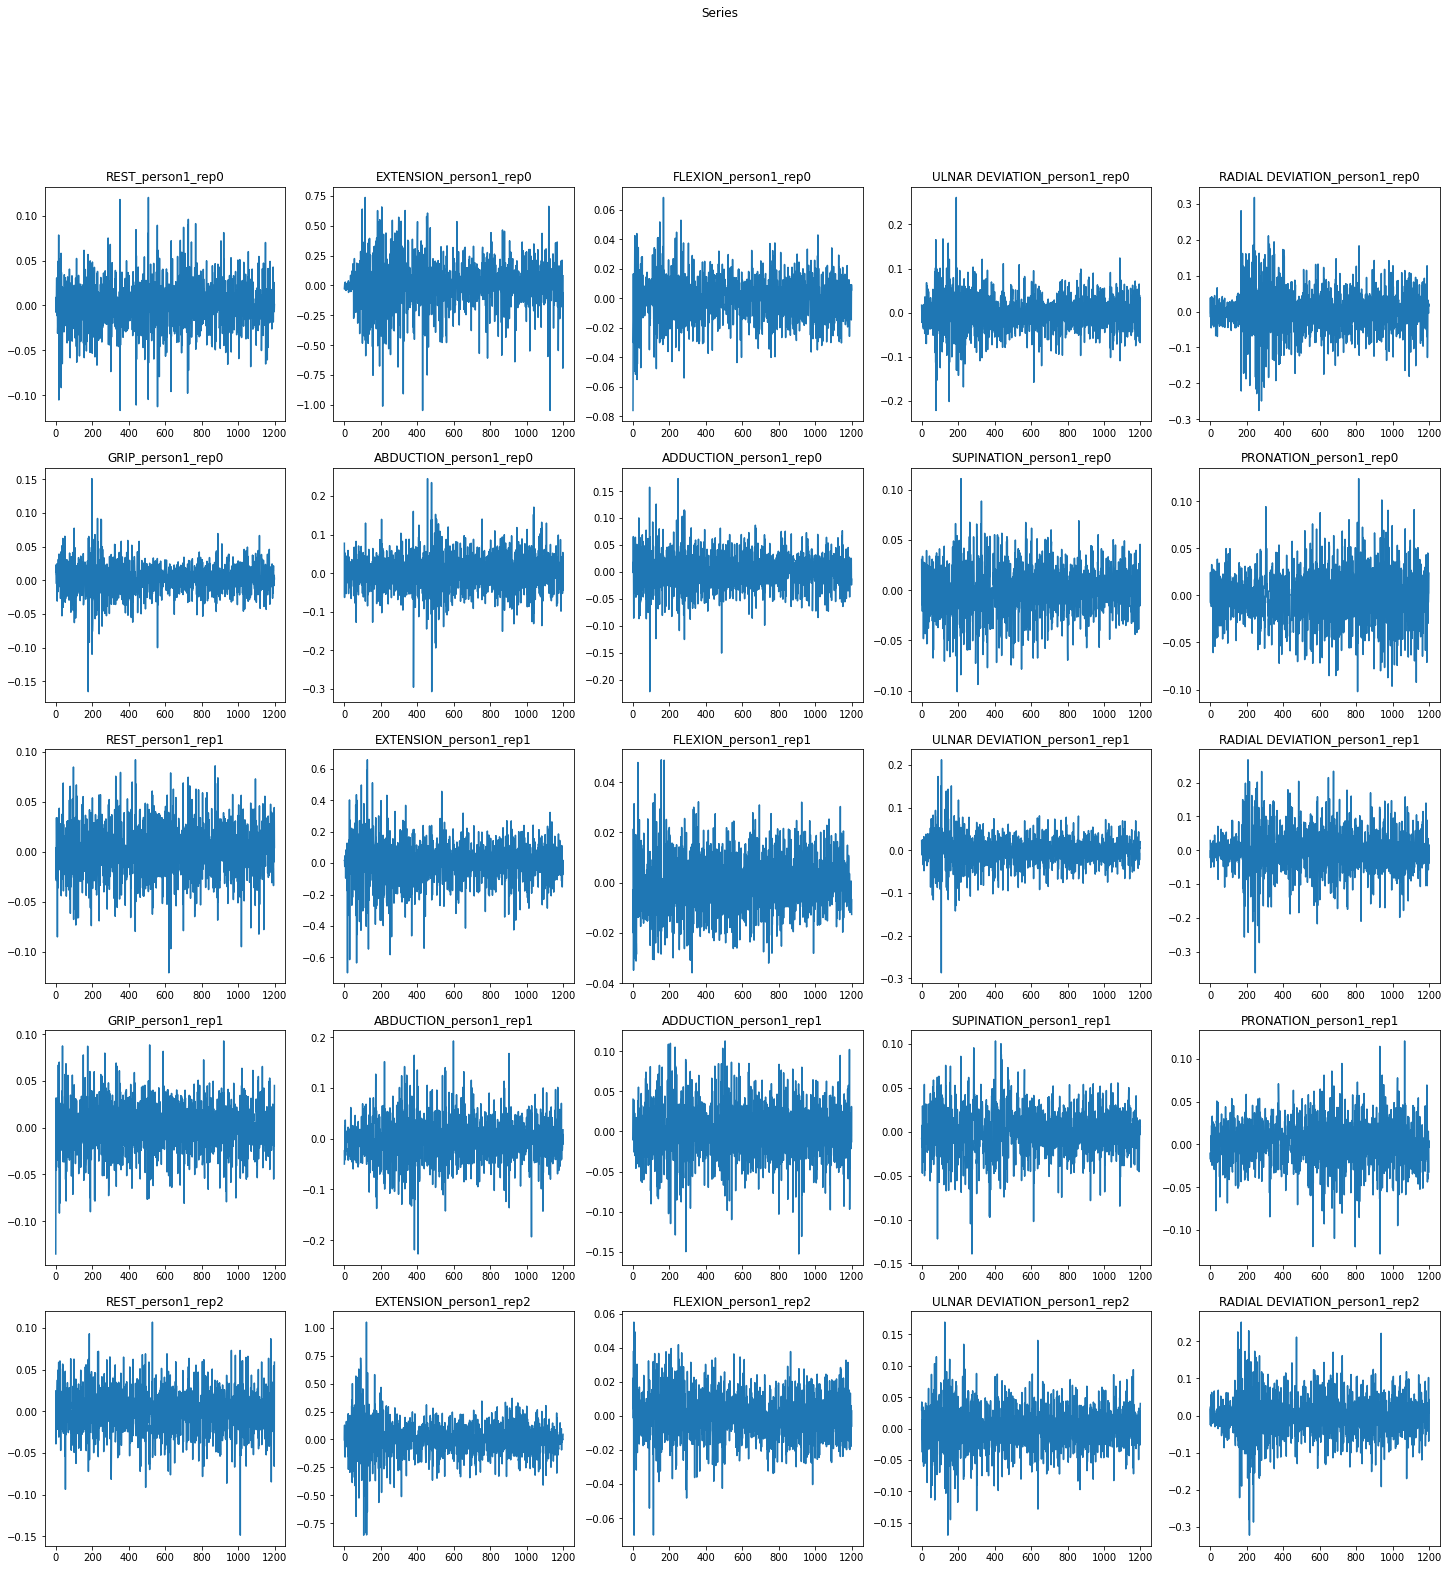

In [56]:
fig, axs = plt.subplots(5,5,figsize=(25,25))
fig.suptitle('Series')
for i in range(5):
    for j in range(5):
        if i*5+j+1>len(mySeries): 
            continue
        axs[i, j].plot(mySeries[i*5+j])
        axs[i, j].set_title(namesofMySeries[i*5+j])
plt.show()

In [57]:
for i in range(len(mySeries)):
    mySeries[i] = MinMaxScaler().fit_transform(mySeries[i].reshape(-1, 1)).reshape(1, -1)[0]


In [59]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries))))
# I didn't see its significance but to make the map square,
# I calculated square root of map size which is 
# the square root of the number of series
# for the row and column counts of som

som = MiniSom(som_x, som_y, len(mySeries[0]), sigma=0.3, learning_rate = 0.1)

som.random_weights_init(mySeries)
som.train(mySeries, 50000)

In [61]:
# Little handy function to plot series
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

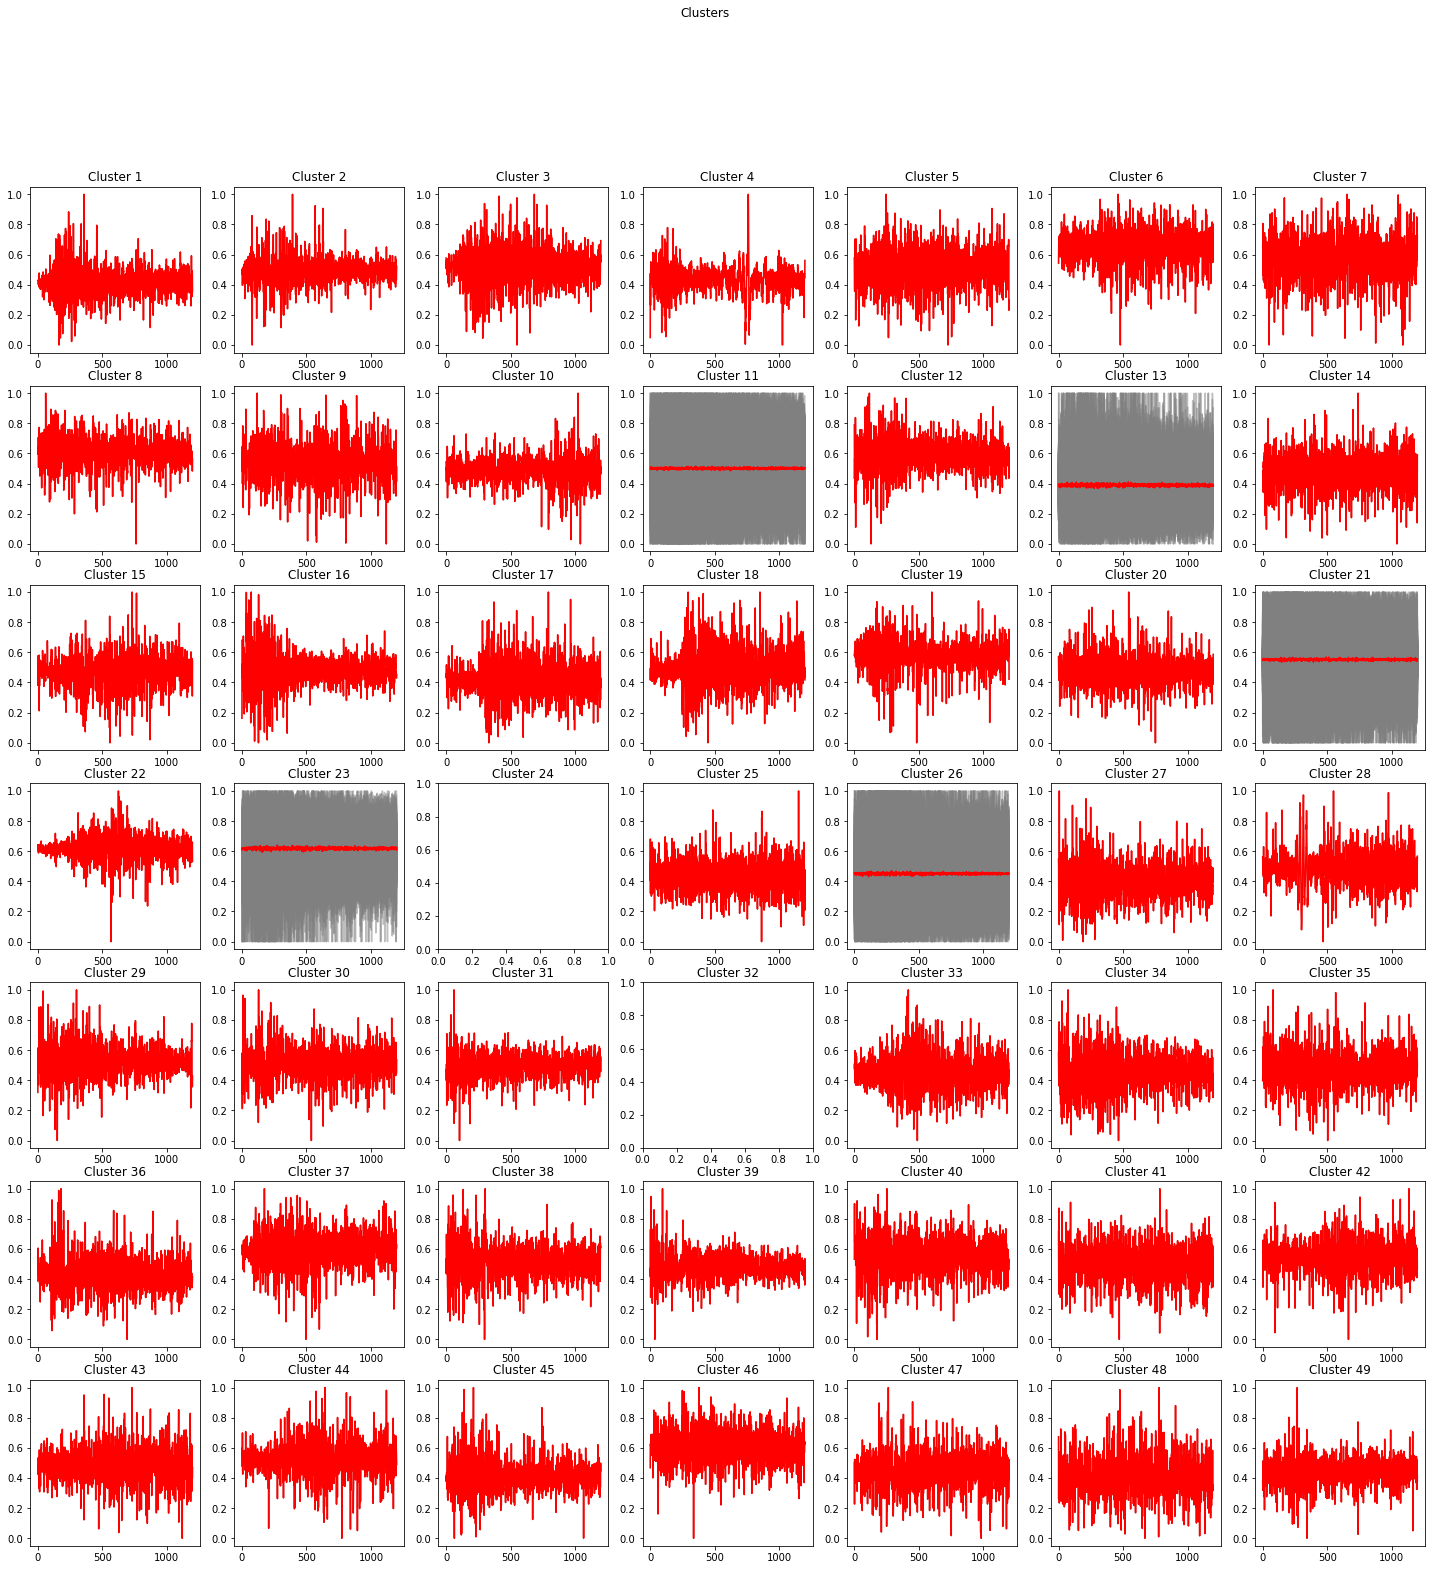

In [62]:
win_map = som.win_map(mySeries)
# Returns the mapping of the winner nodes and inputs

plot_som_series_averaged_center(som_x, som_y, win_map)

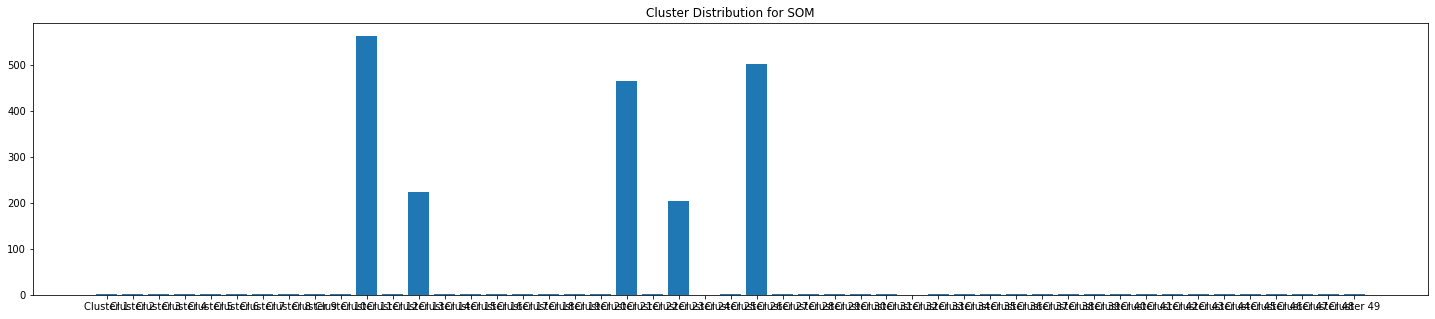

In [63]:
cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")

plt.figure(figsize=(25,5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n,cluster_c)
plt.show()

In [64]:
# Let's check first 5
for series in mySeries[:5]:
    print(som.winner(series))

(1, 3)
(3, 1)
(1, 3)
(3, 4)
(3, 4)


In [65]:
cluster_map = []
for idx in range(len(mySeries)):
    winner_node = som.winner(mySeries[idx])
    cluster_map.append((namesofMySeries[idx],f"Cluster {winner_node[0]*som_y+winner_node[1]+1}"))

pd.DataFrame(cluster_map,columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

,Cluster
Series,
ULNAR DEVIATION_person39_rep4,Cluster 1
PRONATION_person21_rep4,Cluster 10
ULNAR DEVIATION_person24_rep4,Cluster 11
RADIAL DEVIATION_person9_rep2,Cluster 11
GRIP_person9_rep2,Cluster 11
...,...
GRIP_person11_rep0,Cluster 5
REST_person30_rep2,Cluster 6
REST_person2_rep1,Cluster 7


In [54]:
cluster_count = math.ceil(math.sqrt(len(mySeries))) 
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

labels = km.fit_predict(mySeries)


KeyboardInterrupt



In [ ]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

In [ ]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
pd.DataFrame(zip(namesofMySeries,fancy_names_for_labels),columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")